In [ ]:
import pandas as pd
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
train_path = PROJECT_ROOT / "data" / "processed" / "train_dataset.csv"

df = pd.read_csv(train_path)
df["date"] = pd.to_datetime(df["date"])

df.head()


,date,surface,playerA,playerB,eloA,eloB,elo_diff,elo_surfaceA,elo_surfaceB,elo_surface_diff,...,rankA,rankB,rank_diff,oddsA,oddsB,pA_market,pB_market,p_diff,logit_pA_market,y
0,2002-06-10,Grass,Johansson T.,Pretzsch A.,1500.0,1500.0,0.0,1500.0,1500.0,0.0,...,7.0,133.0,-126.0,1.100,6.500,0.855263,0.144737,0.710526,1.776486,1
1,2002-06-10,Grass,Bjorkman J.,Kafelnikov Y.,1500.0,1500.0,0.0,1500.0,1500.0,0.0,...,56.0,6.0,50.0,2.625,1.444,0.354878,0.645122,-0.290243,-0.597663,0
2,2002-06-10,Grass,Koubek S.,Moya C.,1500.0,1500.0,0.0,1500.0,1500.0,0.0,...,41.0,20.0,21.0,2.625,1.444,0.354878,0.645122,-0.290243,-0.597663,1
3,2002-06-10,Grass,Pavel A.,Stepanek R.,1500.0,1500.0,0.0,1500.0,1500.0,0.0,...,21.0,150.0,-129.0,1.533,2.375,0.607728,0.392272,0.215455,0.437770,1
4,2002-06-10,Grass,Stoliarov A.,Sampras P.,1500.0,1500.0,0.0,1500.0,1500.0,0.0,...,107.0,13.0,94.0,5.000,1.143,0.186065,0.813935,-0.627869,-1.475777,0


In [ ]:
import pandas as pd
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
train_path = PROJECT_ROOT / "data" / "processed" / "train_dataset.csv"

df = pd.read_csv(train_path)
df["date"] = pd.to_datetime(df["date"])

df.head()


In [5]:
target_col = "y"

meta_cols = ["date", "surface", "playerA", "playerB"]
all_cols = df.columns.tolist()

feature_cols = [c for c in all_cols if c not in meta_cols + [target_col]]

len(feature_cols), feature_cols[:10]


(27,
 ['eloA',
  'eloB',
  'elo_diff',
  'elo_surfaceA',
  'elo_surfaceB',
  'elo_surface_diff',
  'form_winrateA_5',
  'form_winrateB_5',
  'form_winrate_diff_5',
  'form_winrateA_10'])

In [6]:
# 2022 öncesi train, 2022 ve sonrası validation
split_date = pd.Timestamp("2022-01-01")

train_mask = df["date"] < split_date
val_mask = df["date"] >= split_date

train_df = df[train_mask].copy()
val_df = df[val_mask].copy()

len(train_df), len(val_df)


(47879, 10252)

In [7]:
X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].copy()

X_val = val_df[feature_cols].copy()
y_val = val_df[target_col].copy()


In [9]:
import numpy as np

# Winrate kolonları -> NaN ise 0.5 (tarafsız)
for col in [c for c in X_train.columns if "form_winrate" in c]:
    X_train[col] = X_train[col].fillna(0.5)
    X_val[col] = X_val[col].fillna(0.5)

# days_since_last* kolonları -> NaN ise train medyanı
for col in [c for c in X_train.columns if "days_since_last" in c]:
    median_val = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_val)
    X_val[col] = X_val[col].fillna(median_val)

# Kalan diğer sayısal kolonlar için genel medyan doldurma
for col in X_train.columns:
    if X_train[col].isna().any():
        median_val = X_train[col].median()
        X_train[col] = X_train[col].fillna(median_val)
        X_val[col] = X_val[col].fillna(median_val)


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score

logreg = LogisticRegression(max_iter=1000, n_jobs=-1)

logreg.fit(X_train, y_train)

# Olasılıklar
train_proba = logreg.predict_proba(X_train)[:, 1]
val_proba = logreg.predict_proba(X_val)[:, 1]

# Metrikler
train_logloss = log_loss(y_train, train_proba)
val_logloss = log_loss(y_val, val_proba)

train_brier = brier_score_loss(y_train, train_proba)
val_brier = brier_score_loss(y_val, val_proba)

train_acc = accuracy_score(y_train, (train_proba >= 0.5).astype(int))
val_acc = accuracy_score(y_val, (val_proba >= 0.5).astype(int))

train_logloss, val_logloss, train_brier, val_brier, train_acc, val_acc


(0.5698657974172749,
 0.5858829073910039,
 0.19400733897366465,
 0.2012354182820269,
 0.7012468932099668,
 0.6806476785017558)

In [ ]:
import joblib

models_dir = PROJECT_ROOT / "models"
models_dir.mkdir(parents=True, exist_ok=True)

model_path = models_dir / "logreg_baseline.pkl"
cols_path = models_dir / "feature_columns.txt"

joblib.dump(logreg, model_path)

with open(cols_path, "w") as f:
    for col in feature_cols:
        f.write(col + "\n")
model_path, cols_path

(WindowsPath('C:/Users/alper/predictive-serve/models/logreg_baseline.pkl'),
 WindowsPath('C:/Users/alper/predictive-serve/models/feature_columns.txt'))

In [12]:
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score

# Eğitim seti için metrikler
train_logloss = log_loss(y_train, train_proba)
train_brier   = brier_score_loss(y_train, train_proba)
train_acc     = accuracy_score(y_train, (train_proba >= 0.5).astype(int))

# Validation (test) seti için metrikler
val_logloss = log_loss(y_val, val_proba)
val_brier   = brier_score_loss(y_val, val_proba)
val_acc     = accuracy_score(y_val, (val_proba >= 0.5).astype(int))

print("== TRAIN ==")
print(f"Logloss        : {train_logloss:.4f}")
print(f"Brier score    : {train_brier:.4f}")
print(f"Accuracy       : {train_acc*100:.2f}%")

print("\n== VALIDATION ==")
print(f"Logloss        : {val_logloss:.4f}")
print(f"Brier score    : {val_brier:.4f}")
print(f"Accuracy       : {val_acc*100:.2f}%")


== TRAIN ==
Logloss        : 0.5699
Brier score    : 0.1940
Accuracy       : 70.12%

== VALIDATION ==
Logloss        : 0.5859
Brier score    : 0.2012
Accuracy       : 68.06%


In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

# 0/1 sınıf tahminleri
val_pred = (val_proba >= 0.5).astype(int)

cm = confusion_matrix(y_val, val_pred)
print("Confusion Matrix (validation):")
print(cm)

print("\nClassification report:")
print(classification_report(y_val, val_pred, digits=3))


Confusion Matrix (validation):
[[3473 1682]
 [1592 3505]]

Classification report:
              precision    recall  f1-score   support

           0      0.686     0.674     0.680      5155
           1      0.676     0.688     0.682      5097

    accuracy                          0.681     10252
   macro avg      0.681     0.681     0.681     10252
weighted avg      0.681     0.681     0.681     10252



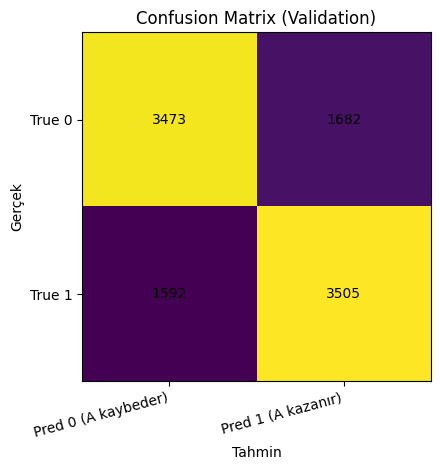

In [14]:
fig, ax = plt.subplots()

im = ax.imshow(cm)

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Pred 0 (A kaybeder)", "Pred 1 (A kazanır)"])
ax.set_yticklabels(["True 0", "True 1"])

plt.setp(ax.get_xticklabels(), rotation=15, ha="right")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")

ax.set_xlabel("Tahmin")
ax.set_ylabel("Gerçek")
ax.set_title("Confusion Matrix (Validation)")
plt.tight_layout()
plt.show()


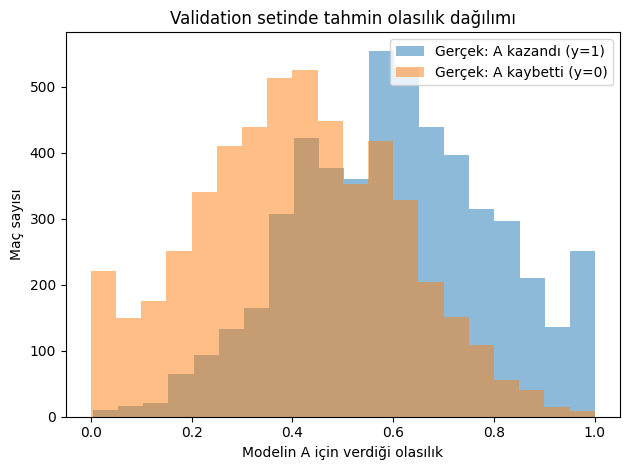

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.hist(val_proba[y_val == 1], bins=20, alpha=0.5, label="Gerçek: A kazandı (y=1)")
ax.hist(val_proba[y_val == 0], bins=20, alpha=0.5, label="Gerçek: A kaybetti (y=0)")

ax.set_xlabel("Modelin A için verdiği olasılık")
ax.set_ylabel("Maç sayısı")
ax.set_title("Validation setinde tahmin olasılık dağılımı")
ax.legend()
plt.tight_layout()
plt.show()


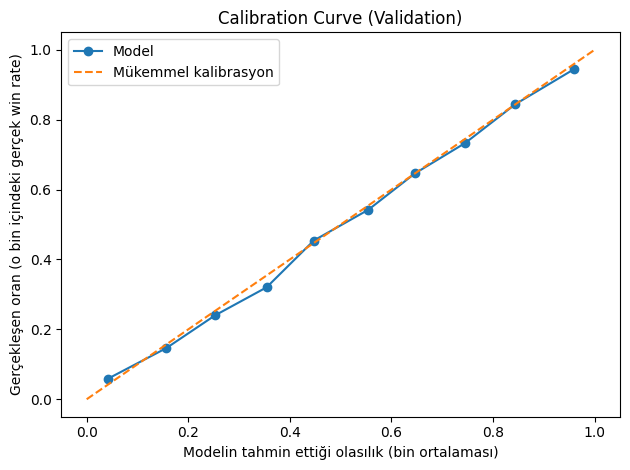

In [16]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_val, val_proba, n_bins=10, strategy="uniform")

fig, ax = plt.subplots()

ax.plot(prob_pred, prob_true, marker="o", label="Model")
ax.plot([0, 1], [0, 1], linestyle="--", label="Mükemmel kalibrasyon")

ax.set_xlabel("Modelin tahmin ettiği olasılık (bin ortalaması)")
ax.set_ylabel("Gerçekleşen oran (o bin içindeki gerçek win rate)")
ax.set_title("Calibration Curve (Validation)")
ax.legend()
plt.tight_layout()
plt.show()


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

val_eval = pd.DataFrame({"y": y_val, "proba": val_proba})

# Olasılık aralıkları (0-0.1, 0.1-0.2, ...)
bins = np.linspace(0, 1, 11)
val_eval["bin"] = pd.cut(val_eval["proba"], bins=bins, include_lowest=True)

bin_stats = (
    val_eval
    .groupby("bin")
    .agg(
        n_matches=("y", "size"),
        mean_proba=("proba", "mean"),
        true_winrate=("y", "mean")
    )
    .reset_index()
)

bin_stats


C:\Users\alper\AppData\Local\Temp\ipykernel_12792\3034578399.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


,bin,n_matches,mean_proba,true_winrate
0,"(-0.001, 0.1]",394,0.041382,0.058376
1,"(0.1, 0.2]",499,0.156718,0.146293
2,"(0.2, 0.3]",987,0.252819,0.240122
3,"(0.3, 0.4]",1402,0.354191,0.320257
4,"(0.4, 0.5]",1783,0.447292,0.454291
5,"(0.5, 0.6]",1684,0.554403,0.542162
6,"(0.6, 0.7]",1506,0.646067,0.646082
7,"(0.7, 0.8]",976,0.745605,0.733607
8,"(0.8, 0.9]",610,0.843885,0.844262
9,"(0.9, 1.0]",411,0.958938,0.944039


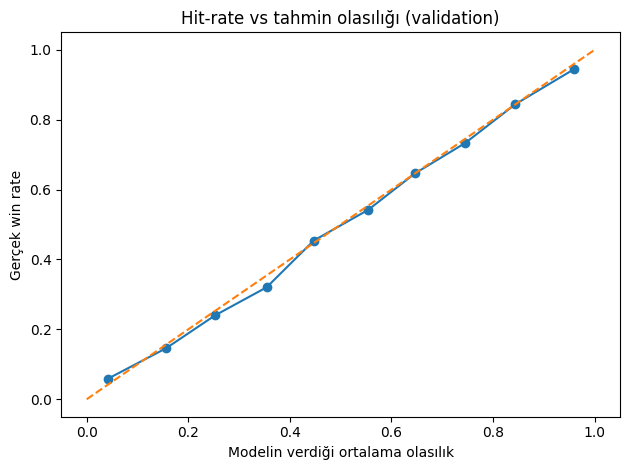

In [18]:
fig, ax = plt.subplots()

ax.plot(bin_stats["mean_proba"], bin_stats["true_winrate"], marker="o")
ax.plot([0, 1], [0, 1], linestyle="--")

ax.set_xlabel("Modelin verdiği ortalama olasılık")
ax.set_ylabel("Gerçek win rate")
ax.set_title("Hit-rate vs tahmin olasılığı (validation)")
plt.tight_layout()
plt.show()


In [19]:
import pandas as pd

# val_df zaten zaman bazlı split'ten geliyordu:
# train_df, val_df = ...

val_eval = val_df.copy()

# Gerçek sonuç (etiket)
val_eval["y"] = y_val.values

# Bizim modelimizin tahmini (p(A kazanır))
val_eval["model_proba"] = val_proba

# Bahis şirketinin tahmini (pA_market: odds'tan gelen probability)
val_eval["market_proba"] = val_eval["pA_market"]

val_eval[["y", "model_proba", "market_proba"]].head()


,y,model_proba,market_proba
47879,1,0.575281,0.588235
47880,1,0.426427,0.411765
47881,0,0.443700,0.430052
47882,0,0.515046,0.526316
47883,1,0.358061,0.343675


In [20]:
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score
import numpy as np

# Model tarafı
model_logloss = log_loss(val_eval["y"], val_eval["model_proba"])
model_brier   = brier_score_loss(val_eval["y"], val_eval["model_proba"])
model_pred    = (val_eval["model_proba"] >= 0.5).astype(int)
model_acc     = accuracy_score(val_eval["y"], model_pred)

# Market tarafı (bahis şirketi)
market_logloss = log_loss(val_eval["y"], val_eval["market_proba"])
market_brier   = brier_score_loss(val_eval["y"], val_eval["market_proba"])
market_pred    = (val_eval["market_proba"] >= 0.5).astype(int)  # 0.5 üstü A favori
market_acc     = accuracy_score(val_eval["y"], market_pred)

results = pd.DataFrame({
    "logloss":  [model_logloss,  market_logloss],
    "brier":    [model_brier,    market_brier],
    "accuracy": [model_acc,      market_acc],
}, index=["Bizim Model", "Bahis Şirketi"])

results


,logloss,brier,accuracy
Bizim Model,0.585883,0.201235,0.680648
Bahis Şirketi,0.585243,0.201148,0.679867


In [21]:
print(f"Bizim model accuracy (validation)  : {model_acc*100:.2f}%")
print(f"Bahis şirketi accuracy (validation): {market_acc*100:.2f}%")


Bizim model accuracy (validation)  : 68.06%
Bahis şirketi accuracy (validation): 67.99%


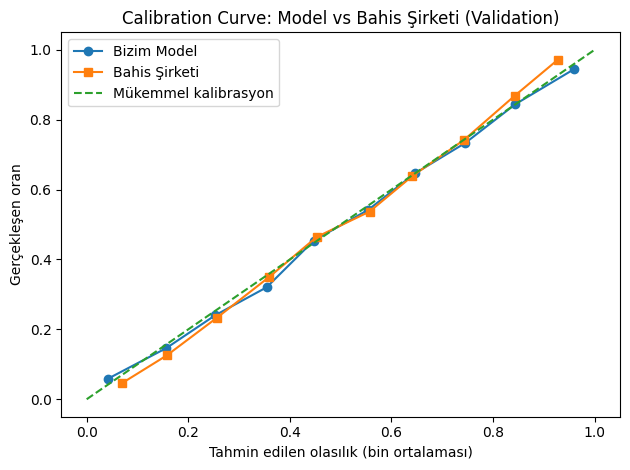

In [22]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Bizim model için calibration
prob_true_model, prob_pred_model = calibration_curve(
    val_eval["y"], val_eval["model_proba"], n_bins=10, strategy="uniform"
)

# Market için calibration
prob_true_market, prob_pred_market = calibration_curve(
    val_eval["y"], val_eval["market_proba"], n_bins=10, strategy="uniform"
)

fig, ax = plt.subplots()

ax.plot(prob_pred_model, prob_true_model, marker="o", label="Bizim Model")
ax.plot(prob_pred_market, prob_true_market, marker="s", label="Bahis Şirketi")
ax.plot([0, 1], [0, 1], linestyle="--", label="Mükemmel kalibrasyon")

ax.set_xlabel("Tahmin edilen olasılık (bin ortalaması)")
ax.set_ylabel("Gerçekleşen oran")
ax.set_title("Calibration Curve: Model vs Bahis Şirketi (Validation)")
ax.legend()
plt.tight_layout()
plt.show()


In [23]:
import numpy as np

# Bin tanımları
bins = np.linspace(0, 1, 11)

val_eval["model_bin"] = pd.cut(val_eval["model_proba"], bins=bins, include_lowest=True)
val_eval["market_bin"] = pd.cut(val_eval["market_proba"], bins=bins, include_lowest=True)

# Bizim model için bin bazlı istatistik
model_bin_stats = (
    val_eval
    .groupby("model_bin")
    .agg(
        n_matches=("y", "size"),
        mean_proba=("model_proba", "mean"),
        true_winrate=("y", "mean"),
    )
    .reset_index()
)

# Market için bin bazlı istatistik
market_bin_stats = (
    val_eval
    .groupby("market_bin")
    .agg(
        n_matches=("y", "size"),
        mean_proba=("market_proba", "mean"),
        true_winrate=("y", "mean"),
    )
    .reset_index()
)

model_bin_stats, market_bin_stats.head()


C:\Users\alper\AppData\Local\Temp\ipykernel_12792\1450487852.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("model_bin")
C:\Users\alper\AppData\Local\Temp\ipykernel_12792\1450487852.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("market_bin")


(       model_bin  n_matches  mean_proba  true_winrate
 0  (-0.001, 0.1]        394    0.041382      0.058376
 1     (0.1, 0.2]        499    0.156718      0.146293
 2     (0.2, 0.3]        987    0.252819      0.240122
 3     (0.3, 0.4]       1402    0.354191      0.320257
 4     (0.4, 0.5]       1783    0.447292      0.454291
 5     (0.5, 0.6]       1684    0.554403      0.542162
 6     (0.6, 0.7]       1506    0.646067      0.646082
 7     (0.7, 0.8]        976    0.745605      0.733607
 8     (0.8, 0.9]        610    0.843885      0.844262
 9     (0.9, 1.0]        411    0.958938      0.944039,
       market_bin  n_matches  mean_proba  true_winrate
 0  (-0.001, 0.1]        219    0.069135      0.045662
 1     (0.1, 0.2]        582    0.157689      0.125430
 2     (0.2, 0.3]       1269    0.255707      0.232467
 3     (0.3, 0.4]       1514    0.359501      0.350066
 4     (0.4, 0.5]       1626    0.452844      0.464330)

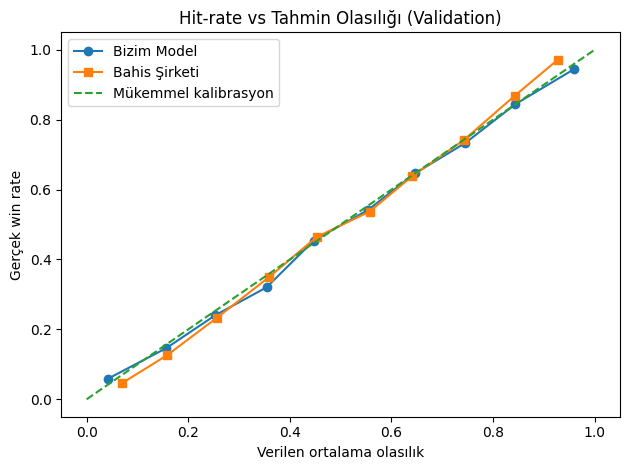

In [24]:
fig, ax = plt.subplots()

ax.plot(model_bin_stats["mean_proba"], model_bin_stats["true_winrate"], marker="o", label="Bizim Model")
ax.plot(market_bin_stats["mean_proba"], market_bin_stats["true_winrate"], marker="s", label="Bahis Şirketi")
ax.plot([0, 1], [0, 1], linestyle="--", label="Mükemmel kalibrasyon")

ax.set_xlabel("Verilen ortalama olasılık")
ax.set_ylabel("Gerçek win rate")
ax.set_title("Hit-rate vs Tahmin Olasılığı (Validation)")
ax.legend()
plt.tight_layout()
plt.show()


In [27]:
import pandas as pd

# val_df: 2022+ maçlar (zaman bazlı split'ten)
# y_val:  2022+ için gerçek etiketler
# val_proba: 2022+ için model tahminleri

val_eval = val_df.copy()

# Gerçek sonuç
val_eval["y"] = y_val.values

# Bizim modelin olasılığı (p(A kazanır))
val_eval["model_proba"] = val_proba

# Bahis şirketinin olasılığı (pA_market)
val_eval["market_proba"] = val_eval["pA_market"]

val_eval[["date", "y", "model_proba", "market_proba"]].head()


,date,y,model_proba,market_proba
47879,2022-01-03,1,0.575281,0.588235
47880,2022-01-03,1,0.426427,0.411765
47881,2022-01-03,0,0.443700,0.430052
47882,2022-01-03,0,0.515046,0.526316
47883,2022-01-04,1,0.358061,0.343675


In [26]:
years = sorted(val_df["date"].dt.year.unique())
rows = []

for year in years:
    sub = val_eval[val_eval["date"].dt.year == year]
    y_sub = sub["y"]
    mp    = sub["model_proba"]
    mkp   = sub["market_proba"]

    model_acc_y  = accuracy_score(y_sub, (mp  >= 0.5).astype(int))
    market_acc_y = accuracy_score(y_sub, (mkp >= 0.5).astype(int))

    rows.append((year, model_acc_y, market_acc_y))

pd.DataFrame(rows, columns=["year", "model_acc", "market_acc"])


,year,model_acc,market_acc
0,2022,0.679290,0.677318
1,2023,0.677135,0.675220
2,2024,0.689878,0.691020
3,2025,0.675948,0.675545


In [29]:
# 2025'te oynanan tüm validation maçlarını al
val_2025 = val_eval[val_eval["date"].dt.year == 2025].copy()

y_2025            = val_2025["y"]
model_proba_25    = val_2025["model_proba"]
market_proba_25   = val_2025["market_proba"]

len(val_2025), val_2025[["date", "playerA", "playerB"]].head()


(2478,
             date       playerA       playerB
 55653 2025-01-01      Bonzi B.      Jarry N.
 55654 2025-01-01   Thompson J.  Michelsen A.
 55655 2025-01-01   Nishioka Y.    Lehecka J.
 55656 2025-01-01   Dimitrov G.      Vukic A.
 55657 2025-01-01  Khachanov K.  Nishikori K.)

In [4]:
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score

# Bizim model (2025)
model_logloss_25 = log_loss(y_2025, model_proba_25)
model_brier_25   = brier_score_loss(y_2025, model_proba_25)
model_acc_25     = accuracy_score(y_2025, (model_proba_25 >= 0.5).astype(int))

# Bahis şirketi (2025)
market_logloss_25 = log_loss(y_2025, market_proba_25)
market_brier_25   = brier_score_loss(y_2025, market_proba_25)
market_acc_25     = accuracy_score(y_2025, (market_proba_25 >= 0.5).astype(int))

print("=== 2025 - Bizim Model ===")
print(f"Logloss : {model_logloss_25:.4f}")
print(f"Brier   : {model_brier_25:.4f}")
print(f"Accuracy: {model_acc_25*100:.2f}%")

print("\n=== 2025 - Bahis Şirketi ===")
print(f"Logloss : {market_logloss_25:.4f}")
print(f"Brier   : {market_brier_25:.4f}")
print(f"Accuracy: {market_acc_25*100:.2f}%")


NameError: name 'y_2025' is not defined

In [2]:
import pandas as pd
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
train_path = PROJECT_ROOT / "data" / "processed" / "train_dataset.csv"

df = pd.read_csv(train_path)
df["date"] = pd.to_datetime(df["date"])

df.head()


,date,surface,playerA,playerB,eloA,eloB,elo_diff,elo_surfaceA,elo_surfaceB,elo_surface_diff,...,oddsB,pA_market,pB_market,p_diff,logit_pA_market,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,y
0,2002-06-10,Grass,Johansson T.,Pretzsch A.,1500.0,1500.0,0.0,1500.0,1500.0,0.0,...,6.500,0.855263,0.144737,0.710526,1.776486,False,False,True,False,1
1,2002-06-10,Grass,Bjorkman J.,Kafelnikov Y.,1500.0,1500.0,0.0,1500.0,1500.0,0.0,...,1.444,0.354878,0.645122,-0.290243,-0.597663,False,False,True,False,0
2,2002-06-10,Grass,Koubek S.,Moya C.,1500.0,1500.0,0.0,1500.0,1500.0,0.0,...,1.444,0.354878,0.645122,-0.290243,-0.597663,False,False,True,False,1
3,2002-06-10,Grass,Pavel A.,Stepanek R.,1500.0,1500.0,0.0,1500.0,1500.0,0.0,...,2.375,0.607728,0.392272,0.215455,0.437770,False,False,True,False,1
4,2002-06-10,Grass,Stoliarov A.,Sampras P.,1500.0,1500.0,0.0,1500.0,1500.0,0.0,...,1.143,0.186065,0.813935,-0.627869,-1.475777,False,False,True,False,0


In [3]:
target_col = "y"
meta_cols = ["date", "surface", "playerA", "playerB"]

all_cols = df.columns.tolist()
feature_cols = [c for c in all_cols if c not in meta_cols + [target_col]]

len(feature_cols), feature_cols[:15]


(31,
 ['eloA',
  'eloB',
  'elo_diff',
  'elo_surfaceA',
  'elo_surfaceB',
  'elo_surface_diff',
  'form_winrateA_5',
  'form_winrateB_5',
  'form_winrate_diff_5',
  'form_winrateA_10',
  'form_winrateB_10',
  'form_winrate_diff_10',
  'days_since_lastA_clipped',
  'days_since_lastB_clipped',
  'days_since_last_diff_clipped'])

In [4]:
split_date = pd.Timestamp("2022-01-01")

train_mask = df["date"] < split_date
val_mask   = df["date"] >= split_date

train_df = df[train_mask].copy()
val_df   = df[val_mask].copy()

X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].copy()

X_val = val_df[feature_cols].copy()
y_val = val_df[target_col].copy()

len(train_df), len(val_df)


(47879, 10252)

In [6]:
import numpy as np

# Winrate kolonları -> NaN ise 0.5 (tarafsız)
for col in [c for c in X_train.columns if "form_winrate" in c]:
    X_train[col] = X_train[col].fillna(0.5)
    X_val[col]   = X_val[col].fillna(0.5)

# days_since_last* kolonları -> NaN ise train medyanı
for col in [c for c in X_train.columns if "days_since_last" in c]:
    median_val = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_val)
    X_val[col]   = X_val[col].fillna(median_val)

# Diğer tüm sayısal kolonlarda kalan NaN'ler -> medyan
for col in X_train.columns:
    if X_train[col].isna().any():
        median_val = X_train[col].median()
        X_train[col] = X_train[col].fillna(median_val)
        X_val[col]   = X_val[col].fillna(median_val)


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score

logreg = LogisticRegression(max_iter=1000, n_jobs=-1)

logreg.fit(X_train, y_train)

train_proba = logreg.predict_proba(X_train)[:, 1]
val_proba   = logreg.predict_proba(X_val)[:, 1]

logreg_train_logloss = log_loss(y_train, train_proba)
logreg_val_logloss   = log_loss(y_val,   val_proba)

logreg_train_brier = brier_score_loss(y_train, train_proba)
logreg_val_brier   = brier_score_loss(y_val,   val_proba)

logreg_train_acc = accuracy_score(y_train, (train_proba >= 0.5).astype(int))
logreg_val_acc   = accuracy_score(y_val,   (val_proba   >= 0.5).astype(int))

logreg_train_logloss, logreg_val_logloss, logreg_train_brier, logreg_val_brier, logreg_train_acc, logreg_val_acc


(0.5686897052704379,
 0.5850300204618627,
 0.19378803271762718,
 0.20104108726840217,
 0.6999519622381419,
 0.6820132657042528)

In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
)

xgb.fit(X_train, y_train)

xgb_train_proba = xgb.predict_proba(X_train)[:, 1]
xgb_val_proba   = xgb.predict_proba(X_val)[:, 1]

xgb_train_logloss = log_loss(y_train, xgb_train_proba)
xgb_val_logloss   = log_loss(y_val,   xgb_val_proba)

xgb_train_brier = brier_score_loss(y_train, xgb_train_proba)
xgb_val_brier   = brier_score_loss(y_val,   xgb_val_proba)

xgb_train_acc = accuracy_score(y_train, (xgb_train_proba >= 0.5).astype(int))
xgb_val_acc   = accuracy_score(y_val,   (xgb_val_proba   >= 0.5).astype(int))

xgb_train_logloss, xgb_val_logloss, xgb_train_brier, xgb_val_brier, xgb_train_acc, xgb_val_acc


(0.5397810904994649,
 0.5854266942928883,
 0.182725753374791,
 0.2013682151611109,
 0.7160968274191191,
 0.6834763948497854)

In [9]:
import pandas as pd

market_proba_val = val_df["pA_market"].values

market_logloss = log_loss(y_val, market_proba_val)
market_brier   = brier_score_loss(y_val, market_proba_val)
market_acc     = accuracy_score(y_val, (market_proba_val >= 0.5).astype(int))

results = pd.DataFrame({
    "logloss_val":  [logreg_val_logloss,  xgb_val_logloss,  market_logloss],
    "brier_val":    [logreg_val_brier,    xgb_val_brier,    market_brier],
    "accuracy_val": [logreg_val_acc,      xgb_val_acc,      market_acc],
}, index=["Logistic Regression", "XGBoost", "Bahis Şirketi"])

results


,logloss_val,brier_val,accuracy_val
Logistic Regression,0.585030,0.201041,0.682013
XGBoost,0.585427,0.201368,0.683476
Bahis Şirketi,0.585243,0.201148,0.679867


In [10]:
import joblib

models_dir = PROJECT_ROOT / "models"
models_dir.mkdir(parents=True, exist_ok=True)

xgb_model_path = models_dir / "xgb_baseline.pkl"
joblib.dump(xgb, xgb_model_path)

xgb_model_path


WindowsPath('C:/Users/alper/predictive-serve/models/xgb_baseline.pkl')

In [11]:
val_export = val_df.copy()

val_export["y"] = y_val.values
val_export["logreg_proba"] = val_proba
val_export["xgb_proba"]    = xgb_val_proba
val_export["market_proba"] = val_export["pA_market"]
val_export["year"] = val_export["date"].dt.year

cols_to_keep = [
    "date",
    "year",
    "surface",
    "playerA",
    "playerB",
    "y",
    "logreg_proba",
    "xgb_proba",
    "market_proba",
]

val_export_out = val_export[cols_to_keep].copy()

preds_path = PROJECT_ROOT / "data" / "processed" / "val_predictions.csv"
preds_path.parent.mkdir(parents=True, exist_ok=True)
val_export_out.to_csv(preds_path, index=False)

preds_path


WindowsPath('C:/Users/alper/predictive-serve/data/processed/val_predictions.csv')

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score

# RandomForest modelini tanımla
rf = RandomForestClassifier(
    n_estimators=400,   # 400 ağaç
    max_depth=None,     # sınırsız derinlik (gerekirse sonra kısaltabiliriz)
    min_samples_leaf=20,  # yaprakta en az 20 örnek (overfit'i azaltır)
    n_jobs=-1,
    random_state=42,
)

# Modeli eğit
rf.fit(X_train, y_train)

# Olasılık tahminleri
rf_train_proba = rf.predict_proba(X_train)[:, 1]
rf_val_proba   = rf.predict_proba(X_val)[:, 1]

# Metrikler
rf_train_logloss = log_loss(y_train, rf_train_proba)
rf_val_logloss   = log_loss(y_val,   rf_val_proba)

rf_train_brier = brier_score_loss(y_train, rf_train_proba)
rf_val_brier   = brier_score_loss(y_val,   rf_val_proba)

rf_train_acc = accuracy_score(y_train, (rf_train_proba >= 0.5).astype(int))
rf_val_acc   = accuracy_score(y_val,   (rf_val_proba   >= 0.5).astype(int))

rf_train_logloss, rf_val_logloss, rf_train_brier, rf_val_brier, rf_train_acc, rf_val_acc


(0.48833810020171703,
 0.5876674665699386,
 0.1606053157635536,
 0.20223723158767698,
 0.7647820547630485,
 0.6797698010144362)

In [13]:
import pandas as pd

from sklearn.metrics import log_loss, brier_score_loss, accuracy_score

# Market (bahis şirketi) metrikleri
market_proba_val = val_df["pA_market"].values

market_logloss = log_loss(y_val, market_proba_val)
market_brier   = brier_score_loss(y_val, market_proba_val)
market_acc     = accuracy_score(y_val, (market_proba_val >= 0.5).astype(int))

results = pd.DataFrame({
    "logloss_val":  [
        logreg_val_logloss,
        xgb_val_logloss,
        rf_val_logloss,
        market_logloss,
    ],
    "brier_val":    [
        logreg_val_brier,
        xgb_val_brier,
        rf_val_brier,
        market_brier,
    ],
    "accuracy_val": [
        logreg_val_acc,
        xgb_val_acc,
        rf_val_acc,
        market_acc,
    ],
}, index=["Logistic Regression", "XGBoost", "RandomForest", "Bahis Şirketi"])

results


,logloss_val,brier_val,accuracy_val
Logistic Regression,0.585030,0.201041,0.682013
XGBoost,0.585427,0.201368,0.683476
RandomForest,0.587667,0.202237,0.679770
Bahis Şirketi,0.585243,0.201148,0.679867


In [14]:
import joblib
from pathlib import Path

models_dir = PROJECT_ROOT / "models"
models_dir.mkdir(parents=True, exist_ok=True)

rf_model_path = models_dir / "rf_baseline.pkl"
joblib.dump(rf, rf_model_path)

rf_model_path


WindowsPath('C:/Users/alper/predictive-serve/models/rf_baseline.pkl')

In [2]:
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path("..").resolve()
train_path = PROJECT_ROOT / "data" / "processed" / "train_dataset.csv"

df = pd.read_csv(train_path)
df["date"] = pd.to_datetime(df["date"])

df.head()


,date,surface,playerA,playerB,eloA,eloB,elo_diff,elo_surfaceA,elo_surfaceB,elo_surface_diff,...,oddsB,pA_market,pB_market,p_diff,logit_pA_market,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,y
0,2002-06-10,Grass,Johansson T.,Pretzsch A.,1500.0,1500.0,0.0,1500.0,1500.0,0.0,...,6.500,0.855263,0.144737,0.710526,1.776486,False,False,True,False,1
1,2002-06-10,Grass,Ilie A.,Morrison J.,1500.0,1500.0,0.0,1500.0,1500.0,0.0,...,1.571,0.411149,0.588851,-0.177702,-0.359217,False,False,True,False,0
2,2002-06-10,Grass,Lee H.T.,Larsson M.,1500.0,1500.0,0.0,1500.0,1500.0,0.0,...,1.444,0.354878,0.645122,-0.290243,-0.597663,False,False,True,False,1
3,2002-06-10,Grass,Godwin N.,Gasquet R.,1500.0,1500.0,0.0,1500.0,1500.0,0.0,...,2.375,0.607728,0.392272,0.215455,0.437770,False,False,True,False,1
4,2002-06-10,Grass,Santoro F.,Youzhny M.,1500.0,1500.0,0.0,1500.0,1500.0,0.0,...,1.800,0.485306,0.514694,-0.029388,-0.058793,False,False,True,False,0


In [3]:
meta_cols = ["date", "surface", "playerA", "playerB", "y"]
feature_cols = [c for c in df.columns if c not in meta_cols]

len(feature_cols), feature_cols[:10]


(42,
 ['eloA',
  'eloB',
  'elo_diff',
  'elo_surfaceA',
  'elo_surfaceB',
  'elo_surface_diff',
  'form_winrateA_5',
  'form_winrateB_5',
  'form_winrate_diff_5',
  'form_winrateA_10'])

In [17]:
# 2022'den önceki maçlar: train
train_df = df[df["date"].dt.year < 2022].copy()
val_df   = df[df["date"].dt.year >= 2022].copy()

X_train = train_df[feature_cols]
y_train = train_df["y"]

X_val   = val_df[feature_cols]
y_val   = val_df["y"]

X_train.shape, X_val.shape


((47879, 39), (10252, 39))

In [18]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_val_imp   = imputer.transform(X_val)


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score

logreg = LogisticRegression(
    penalty="l2",
    C=1.0,
    max_iter=1000,
    n_jobs=-1,
    solver="lbfgs",
)

logreg.fit(X_train_imp, y_train)

logreg_train_proba = logreg.predict_proba(X_train_imp)[:, 1]
logreg_val_proba   = logreg.predict_proba(X_val_imp)[:, 1]

logreg_train_logloss = log_loss(y_train, logreg_train_proba)
logreg_val_logloss   = log_loss(y_val,   logreg_val_proba)

logreg_train_brier = brier_score_loss(y_train, logreg_train_proba)
logreg_val_brier   = brier_score_loss(y_val,   logreg_val_proba)

logreg_train_acc = accuracy_score(y_train, (logreg_train_proba >= 0.5).astype(int))
logreg_val_acc   = accuracy_score(y_val,   (logreg_val_proba   >= 0.5).astype(int))

logreg_train_logloss, logreg_val_logloss, logreg_val_acc


(0.5697857586386871, 0.5858601415085591, 0.6806476785017558)

In [20]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
)

xgb.fit(X_train_imp, y_train)

xgb_train_proba = xgb.predict_proba(X_train_imp)[:, 1]
xgb_val_proba   = xgb.predict_proba(X_val_imp)[:, 1]

xgb_train_logloss = log_loss(y_train, xgb_train_proba)
xgb_val_logloss   = log_loss(y_val,   xgb_val_proba)

xgb_train_brier = brier_score_loss(y_train, xgb_train_proba)
xgb_val_brier   = brier_score_loss(y_val,   xgb_val_proba)

xgb_train_acc = accuracy_score(y_train, (xgb_train_proba >= 0.5).astype(int))
xgb_val_acc   = accuracy_score(y_val,   (xgb_val_proba   >= 0.5).astype(int))

xgb_train_logloss, xgb_val_logloss, xgb_val_acc


(0.5396697883095092, 0.5859635636841695, 0.6788919235271167)

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=20,
    n_jobs=-1,
    random_state=42,
)

rf.fit(X_train_imp, y_train)

rf_train_proba = rf.predict_proba(X_train_imp)[:, 1]
rf_val_proba   = rf.predict_proba(X_val_imp)[:, 1]

rf_train_logloss = log_loss(y_train, rf_train_proba)
rf_val_logloss   = log_loss(y_val,   rf_val_proba)

rf_train_brier = brier_score_loss(y_train, rf_train_proba)
rf_val_brier   = brier_score_loss(y_val,   rf_val_proba)

rf_train_acc = accuracy_score(y_train, (rf_train_proba >= 0.5).astype(int))
rf_val_acc   = accuracy_score(y_val,   (rf_val_proba   >= 0.5).astype(int))

rf_train_logloss, rf_val_logloss, rf_val_acc


(0.48903596861083004, 0.5873585752122147, 0.6799648849005072)

In [1]:
import pandas as pd

market_proba_val = val_df["pA_market"].values

market_logloss = log_loss(y_val, market_proba_val)
market_brier   = brier_score_loss(y_val, market_proba_val)
market_acc     = accuracy_score(y_val, (market_proba_val >= 0.5).astype(int))

results = pd.DataFrame({
    "logloss_val":  [
        logreg_val_logloss,
        xgb_val_logloss,
        rf_val_logloss,
        market_logloss,
    ],
    "brier_val":    [
        logreg_val_brier,
        xgb_val_brier,
        rf_val_brier,
        market_brier,
    ],
    "accuracy_val": [
        logreg_val_acc,
        xgb_val_acc,
        rf_val_acc,
        market_acc,
    ],
}, index=["Logistic Regression", "XGBoost", "RandomForest", "Bahis Şirketi"])

results


NameError: name 'val_df' is not defined

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

PROJECT_ROOT = Path("..").resolve()
train_path = PROJECT_ROOT / "data" / "processed" / "train_dataset.csv"

df = pd.read_csv(train_path)
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Time-based split: 2022 öncesi train, 2022 ve sonrası validation
train_mask = df["date"].dt.year < 2022
val_mask = df["date"].dt.year >= 2022

# Hangi kolonlar *feature* değil, onları çıkarıyoruz
non_feature_cols = ["date", "surface", "playerA", "playerB", "y"]
feature_cols = [c for c in df.columns if c not in non_feature_cols]

X_train = df.loc[train_mask, feature_cols]
y_train = df.loc[train_mask, "y"]

X_val = df.loc[val_mask, feature_cols]
y_val = df.loc[val_mask, "y"]

# Eksik değerleri median ile doldur (modelden önce)
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_val_imp = imputer.transform(X_val)

X_train_imp.shape, X_val_imp.shape, len(feature_cols)


((47879, 42), (10252, 42), 42)

In [2]:
logreg = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    n_jobs=-1,
)

logreg.fit(X_train_imp, y_train)

proba_logreg = logreg.predict_proba(X_val_imp)[:, 1]
pred_logreg = (proba_logreg >= 0.5).astype(int)

logloss_logreg = log_loss(y_val, proba_logreg)
brier_logreg = brier_score_loss(y_val, proba_logreg)
acc_logreg = accuracy_score(y_val, pred_logreg)

logloss_logreg, brier_logreg, acc_logreg


(0.585147744350525, 0.20132044620318143, 0.6803550526726493)

In [3]:
xgb = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="binary:logistic",
    eval_metric="logloss",
    n_jobs=-1,
    random_state=42,
    tree_method="hist",  # Windows + modern xgboost için hızlı
)

xgb.fit(X_train_imp, y_train)

proba_xgb = xgb.predict_proba(X_val_imp)[:, 1]
pred_xgb = (proba_xgb >= 0.5).astype(int)

logloss_xgb = log_loss(y_val, proba_xgb)
brier_xgb = brier_score_loss(y_val, proba_xgb)
acc_xgb = accuracy_score(y_val, pred_xgb)

logloss_xgb, brier_xgb, acc_xgb


(0.5861922244519808, 0.20183847435759328, 0.6779165040967616)

In [4]:
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=20,
    min_samples_leaf=20,
    n_jobs=-1,
    random_state=42,
)

rf.fit(X_train_imp, y_train)

proba_rf = rf.predict_proba(X_val_imp)[:, 1]
pred_rf = (proba_rf >= 0.5).astype(int)

logloss_rf = log_loss(y_val, proba_rf)
brier_rf = brier_score_loss(y_val, proba_rf)
acc_rf = accuracy_score(y_val, pred_rf)

logloss_rf, brier_rf, acc_rf


(0.587393057648656, 0.2023163798182543, 0.6789894654701522)

In [5]:
val_df = df.loc[val_mask].copy()

market_proba = val_df["pA_market"].values
market_pred = (market_proba >= 0.5).astype(int)

logloss_market = log_loss(y_val, market_proba)
brier_market = brier_score_loss(y_val, market_proba)
acc_market = accuracy_score(y_val, market_pred)

logloss_market, brier_market, acc_market


(0.5852431639109311, 0.2011482771373408, 0.6793796332422942)

In [8]:
results = pd.DataFrame(
    {
        "logloss_val": {
            "Logistic Regression": logloss_logreg,
            "XGBoost": logloss_xgb,
            "RandomForest": logloss_rf,
            "Bahis Şirketi": logloss_market,
        },
        "brier_val": {
            "Logistic Regression": brier_logreg,
            "XGBoost": brier_xgb,
            "RandomForest": brier_rf,
            "Bahis Şirketi": brier_market,
        },
        "accuracy_val": {
            "Logistic Regression": acc_logreg,
            "XGBoost": acc_xgb,
            "RandomForest": acc_rf,
            "Bahis Şirketi": acc_market,
        },
    }
)

results


,logloss_val,brier_val,accuracy_val
Logistic Regression,0.585148,0.201320,0.680355
XGBoost,0.586192,0.201838,0.677917
RandomForest,0.587393,0.202316,0.678989
Bahis Şirketi,0.585243,0.201148,0.679380


In [5]:
from pathlib import Path
import pandas as pd

ROOT = Path("..").resolve()          # notebook /notebooks içindeyse
DATASET_PATH = ROOT / "data" / "processed" / "train_dataset.csv"
FEATURE_LIST_PATH = ROOT / "models" / "feature_columns.txt"

print("ROOT:", ROOT)
print("DATASET_PATH exists?:", DATASET_PATH.exists(), DATASET_PATH)
print("FEATURE_LIST_PATH exists?:", FEATURE_LIST_PATH.exists(), FEATURE_LIST_PATH)


ROOT: C:\Users\alper\predictive-serve
DATASET_PATH exists?: True C:\Users\alper\predictive-serve\data\processed\train_dataset.csv
FEATURE_LIST_PATH exists?: True C:\Users\alper\predictive-serve\models\feature_columns.txt


In [6]:
df = pd.read_csv(DATASET_PATH)

print("Rows:", len(df))
print("Cols:", len(df.columns))

# Kolonları alfabetik sırada yaz
all_cols = sorted(df.columns.tolist())
for c in all_cols:
    print(c)


Rows: 58131
Cols: 47
date
days_since_lastA_clipped
days_since_lastB_clipped
days_since_last_diff_clipped
eloA
eloB
elo_diff
elo_surfaceA
elo_surfaceB
elo_surface_diff
form_winrateA_10
form_winrateA_5
form_winrateB_10
form_winrateB_5
form_winrate_diff_10
form_winrate_diff_5
h2h_matches
h2h_winrateA
h2h_winrateB
h2h_winrate_diff
is_bo5_match
is_final
is_grand_slam
is_quarter
is_semi
logit_pA_market
matches_last30A
matches_last30B
matches_last30_diff
oddsA
oddsB
pA_market
pB_market
p_diff
playerA
playerB
rankA
rankB
rank_diff
round_importance
series_tier
surface
surface_Carpet
surface_Clay
surface_Grass
surface_Hard
y


In [7]:
if FEATURE_LIST_PATH.exists():
    feature_cols_model = [line.strip() for line in FEATURE_LIST_PATH.read_text(encoding="utf-8").splitlines() if line.strip()]

    print("Model feature count:", len(feature_cols_model))
    print("\n--- MODEL FEATURES (feature_columns.txt) ---")
    for c in feature_cols_model:
        print(c)

    # Dataset'te olup olmadığını kontrol et
    missing = [c for c in feature_cols_model if c not in df.columns]
    extra = [c for c in df.columns if c not in feature_cols_model]

    print("\nMissing in dataset (listed in txt but not in df):", missing[:50], "..." if len(missing) > 50 else "")
    print("Extra in dataset (in df but not in txt):", extra[:50], "..." if len(extra) > 50 else "")
else:
    print("feature_columns.txt yok. Modelin kullandığı feature'ları görmek için training script'in bunu üretmesi gerekir.")


Model feature count: 42

--- MODEL FEATURES (feature_columns.txt) ---
eloA
eloB
elo_diff
elo_surfaceA
elo_surfaceB
elo_surface_diff
form_winrateA_5
form_winrateB_5
form_winrate_diff_5
form_winrateA_10
form_winrateB_10
form_winrate_diff_10
days_since_lastA_clipped
days_since_lastB_clipped
days_since_last_diff_clipped
matches_last30A
matches_last30B
matches_last30_diff
rankA
rankB
rank_diff
h2h_matches
h2h_winrateA
h2h_winrateB
h2h_winrate_diff
round_importance
is_final
is_semi
is_quarter
series_tier
is_grand_slam
is_bo5_match
oddsA
oddsB
pA_market
pB_market
p_diff
logit_pA_market
surface_Carpet
surface_Clay
surface_Grass
surface_Hard

Missing in dataset (listed in txt but not in df): [] 
Extra in dataset (in df but not in txt): ['date', 'surface', 'playerA', 'playerB', 'y'] 


In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# --- Paths ---
ROOT = Path("..").resolve()  # notebook /notebooks içindeyse
DATASET_PATH = ROOT / "data" / "processed" / "train_dataset.csv"
FEATURE_LIST_PATH = ROOT / "models" / "feature_columns.txt"  # varsa kullanacağız

# --- Load dataset ---
df = pd.read_csv(DATASET_PATH)

# Label kolon adı (projende y kullanıyordunuz)
TARGET_COL = "y" if "y" in df.columns else "target"
assert TARGET_COL in df.columns, f"Label kolonu bulunamadı. df.columns: {df.columns.tolist()}"

# Date split için date kolonu
assert "date" in df.columns, "date kolonu yok. Split için date gerekiyor."
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# --- Feature columns (EN GÜVENLİSİ: feature_columns.txt varsa onu kullan) ---
if FEATURE_LIST_PATH.exists():
    feature_cols = [l.strip() for l in FEATURE_LIST_PATH.read_text(encoding="utf-8").splitlines() if l.strip()]
else:
    # Yoksa: sayısal kolonlardan label ve bariz meta'ları çıkar
    meta_like = {"date", "playerA", "playerB", "surface", "round", TARGET_COL}
    numeric_cols = df.select_dtypes(include="number").columns.tolist()
    feature_cols = [c for c in numeric_cols if c not in meta_like]

# --- Train/Val split (zaman bazlı) ---
cutoff = pd.Timestamp("2022-01-01")
train_df = df[df["date"] < cutoff].copy()
val_df   = df[df["date"] >= cutoff].copy()

assert len(train_df) > 0 and len(val_df) > 0, "Train/Val boş çıktı. cutoff tarihini değiştirmen gerekebilir."

X_train = train_df[feature_cols]
y_train = train_df[TARGET_COL].astype(int)

X_val = val_df[feature_cols]
y_val = val_df[TARGET_COL].astype(int)

# --- Baselines / Models ---
results = []

def eval_proba(name, p1):
    """p1: class-1 olasılığı"""
    p1 = np.clip(np.asarray(p1), 1e-6, 1-1e-6)
    y_pred = (p1 >= 0.5).astype(int)
    acc = accuracy_score(y_val, y_pred)
    try:
        auc = roc_auc_score(y_val, p1)
    except Exception:
        auc = np.nan
    try:
        ll = log_loss(y_val, np.column_stack([1-p1, p1]))
    except Exception:
        ll = np.nan
    results.append({
        "Model": name,
        "Accuracy %": round(acc * 100, 2),
        "AUC": round(float(auc), 4) if np.isfinite(auc) else None,
        "LogLoss": round(float(ll), 4) if np.isfinite(ll) else None
    })

# 1) Market baseline (pA_market varsa)
if "pA_market" in val_df.columns:
    eval_proba("Market baseline (pA_market)", val_df["pA_market"].values)
elif "oddsA" in val_df.columns and "oddsB" in val_df.columns:
    # odds -> implied prob (basit)
    pA = (1.0 / val_df["oddsA"].replace(0, np.nan)).values
    pB = (1.0 / val_df["oddsB"].replace(0, np.nan)).values
    # normalize (overround düzeltmesi)
    denom = np.nan_to_num(pA + pB, nan=1.0)
    pA_norm = np.nan_to_num(pA / denom, nan=0.5)
    eval_proba("Market baseline (from odds)", pA_norm)

# 2) Logistic Regression
logreg = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, n_jobs=None))
])
logreg.fit(X_train, y_train)
p1 = logreg.predict_proba(X_val)[:, 1]
eval_proba("Logistic Regression", p1)

# 3) Random Forest
rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(
        n_estimators=500,
        random_state=42,
        n_jobs=-1,
        class_weight=None
    ))
])
rf.fit(X_train, y_train)
p1 = rf.predict_proba(X_val)[:, 1]
eval_proba("Random Forest", p1)

# 4) XGBoost (kuruluysa)
try:
    from xgboost import XGBClassifier
    xgb = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", XGBClassifier(
            n_estimators=800,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            random_state=42,
            eval_metric="logloss",
            n_jobs=-1
        ))
    ])
    xgb.fit(X_train, y_train)
    p1 = xgb.predict_proba(X_val)[:, 1]
    eval_proba("XGBoost", p1)
except Exception as e:
    results.append({"Model": "XGBoost", "Accuracy %": None, "AUC": None, "LogLoss": f"Skip ({type(e).__name__})"})

# --- Show results ---
res_df = pd.DataFrame(results).sort_values(by="Accuracy %", ascending=False, na_position="last")
display(res_df)

print("\nKullanılan feature sayısı:", len(feature_cols))
print("Train rows:", len(train_df), "Val rows:", len(val_df))


,Model,Accuracy %,AUC,LogLoss
1,Logistic Regression,68.01,0.7537,0.5849
0,Market baseline (pA_market),67.94,0.7538,0.5852
2,Random Forest,67.66,0.7418,0.5951
3,XGBoost,67.63,0.7457,0.5921



Kullanılan feature sayısı: 42
Train rows: 47879 Val rows: 10252


In [3]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, brier_score_loss

# Proje kök dizini (notebook /notebooks içindeyse)
ROOT = Path("..").resolve()
DATA_PATH = ROOT / "data" / "processed" / "train_dataset.csv"
FEATURE_LIST_PATH = ROOT / "models" / "feature_columns.txt"

df = pd.read_csv(DATA_PATH)
df["date"] = pd.to_datetime(df["date"], errors="coerce")

print("Toplam satır:", len(df))
df.head()

Toplam satır: 58131


,date,surface,playerA,playerB,eloA,eloB,elo_diff,elo_surfaceA,elo_surfaceB,elo_surface_diff,...,oddsB,pA_market,pB_market,p_diff,logit_pA_market,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,y
0,2002-06-10,Grass,Johansson T.,Pretzsch A.,1500.0,1500.0,0.0,1500.0,1500.0,0.0,...,6.500,0.855263,0.144737,0.710526,1.776486,False,False,True,False,1
1,2002-06-10,Grass,Ilie A.,Morrison J.,1500.0,1500.0,0.0,1500.0,1500.0,0.0,...,1.571,0.411149,0.588851,-0.177702,-0.359217,False,False,True,False,0
2,2002-06-10,Grass,Lee H.T.,Larsson M.,1500.0,1500.0,0.0,1500.0,1500.0,0.0,...,1.444,0.354878,0.645122,-0.290243,-0.597663,False,False,True,False,1
3,2002-06-10,Grass,Godwin N.,Gasquet R.,1500.0,1500.0,0.0,1500.0,1500.0,0.0,...,2.375,0.607728,0.392272,0.215455,0.437770,False,False,True,False,1
4,2002-06-10,Grass,Santoro F.,Youzhny M.,1500.0,1500.0,0.0,1500.0,1500.0,0.0,...,1.800,0.485306,0.514694,-0.029388,-0.058793,False,False,True,False,0


In [4]:
TARGET_COL = "y"
assert TARGET_COL in df.columns, f"Target kolon ({TARGET_COL}) bulunamadı"

# Mümkünse prod modelde kullanılan kolon listesini kullan
if FEATURE_LIST_PATH.exists():
    feature_cols = [
        line.strip()
        for line in FEATURE_LIST_PATH.read_text(encoding="utf-8").splitlines()
        if line.strip()
    ]
    print("feature_columns.txt yüklendi. Feature sayısı:", len(feature_cols))
else:
    # Yedek: sayısal kolonlardan bariz meta kolonları çıkar
    meta_like = {"date", "playerA", "playerB", "surface", TARGET_COL}
    numeric_cols = df.select_dtypes(include="number").columns.tolist()
    feature_cols = [c for c in numeric_cols if c not in meta_like]
    print("feature_columns.txt bulunamadı, otomatik feature seçimi. Feature sayısı:", len(feature_cols))

feature_cols[:10]

feature_columns.txt yüklendi. Feature sayısı: 42


['eloA',
 'eloB',
 'elo_diff',
 'elo_surfaceA',
 'elo_surfaceB',
 'elo_surface_diff',
 'form_winrateA_5',
 'form_winrateB_5',
 'form_winrate_diff_5',
 'form_winrateA_10']

In [5]:
# Basit bir Logistic Regression pipeline'ı
model_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, n_jobs=None))
])

model_pipeline

,steps,"[('imputer', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [6]:
years_to_eval = [2023, 2024, 2025]

results = []

for year in years_to_eval:
    cutoff_date = pd.Timestamp(f"{year}-01-01")
    
    # Train: cutoff öncesi tüm veriler
    train_mask = df["date"] < cutoff_date
    
    # Test: ilgili yılın tüm maçları
    test_mask = df["date"].dt.year == year
    
    train_df = df[train_mask].copy()
    test_df  = df[test_mask].copy()
    
    print(f"\n=== {year} ===")
    print("Train satır:", len(train_df), "Test satır:", len(test_df))
    
    if len(train_df) == 0 or len(test_df) == 0:
        print("Bu yıl için yeterli train/test veri yok, SKIP.")
        continue
    
    X_train = train_df[feature_cols]
    y_train = train_df[TARGET_COL].astype(int)
    
    X_test = test_df[feature_cols]
    y_test = test_df[TARGET_COL].astype(int)
    
    # Modeli sadece o yıl için yeniden eğit
    model = model_pipeline
    model.fit(X_train, y_train)
    
    proba_test = model.predict_proba(X_test)[:, 1]
    y_pred = (proba_test >= 0.5).astype(int)
    
    acc   = accuracy_score(y_test, y_pred)
    ll    = log_loss(y_test, proba_test)
    brier = brier_score_loss(y_test, proba_test)
    
    print(f"Accuracy: {acc*100:.2f}% | LogLoss: {ll:.4f} | Brier: {brier:.4f}")
    
    results.append({
        "year": year,
        "n_train": len(train_df),
        "n_test": len(test_df),
        "accuracy": acc,
        "logloss": ll,
        "brier": brier,
    })

results_df = pd.DataFrame(results)
results_df


=== 2023 ===
Train satır: 50414 Test satır: 2611
Accuracy: 67.41% | LogLoss: 0.5870 | Brier: 0.2026

=== 2024 ===
Train satır: 53025 Test satır: 2628
Accuracy: 69.14% | LogLoss: 0.5810 | Brier: 0.1991

=== 2025 ===
Train satır: 55653 Test satır: 2478
Accuracy: 67.68% | LogLoss: 0.5938 | Brier: 0.2050


,year,n_train,n_test,accuracy,logloss,brier
0,2023,50414,2611,0.674071,0.587023,0.202640
1,2024,53025,2628,0.691400,0.581035,0.199070
2,2025,55653,2478,0.676755,0.593751,0.205032


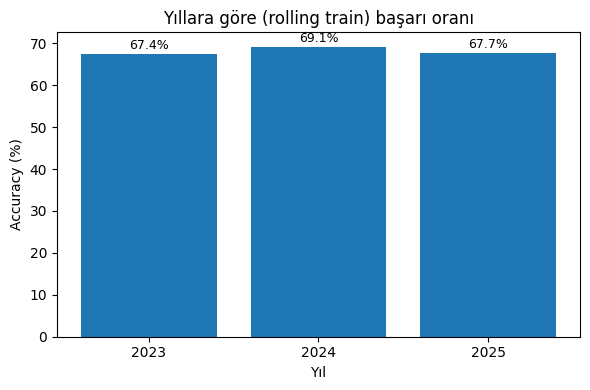

In [7]:
import matplotlib.pyplot as plt

if not results_df.empty:
    fig, ax = plt.subplots(figsize=(6, 4))
    
    ax.bar(results_df["year"].astype(str), results_df["accuracy"] * 100)
    ax.set_xlabel("Yıl")
    ax.set_ylabel("Accuracy (%)")
    ax.set_title("Yıllara göre (rolling train) başarı oranı")
    for i, row in results_df.iterrows():
        ax.text(
            i,
            row["accuracy"] * 100 + 0.5,
            f"{row['accuracy']*100:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9,
        )
    plt.tight_layout()
    plt.show()
else:
    print("Gösterilecek sonuç yok (results_df boş).")

In [8]:
from sklearn.ensemble import RandomForestClassifier

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

def get_models():
    """Değerlendirilecek modelleri (isim, sklearn estimator) olarak döner."""
    models = {}

    # Logistic Regression
    logreg_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, n_jobs=None)),
    ])
    models["LogisticRegression"] = logreg_pipe

    # RandomForest
    rf_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", RandomForestClassifier(
            n_estimators=500,
            max_depth=None,
            min_samples_leaf=20,
            random_state=42,
            n_jobs=-1,
        )),
    ])
    models["RandomForest"] = rf_pipe

    # XGBoost (varsa)
    if HAS_XGB:
        xgb_pipe = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("clf", XGBClassifier(
                n_estimators=400,
                max_depth=4,
                learning_rate=0.05,
                subsample=0.9,
                colsample_bytree=0.9,
                eval_metric="logloss",
                n_jobs=-1,
                random_state=42,
                tree_method="hist",
            )),
        ])
        models["XGBoost"] = xgb_pipe

    return models


def get_market_proba(sub_df: pd.DataFrame) -> np.ndarray:
    """
    Market (bahis) tarafının A kazanır olasılığı:
    - Tercihen pA_market
    - Yoksa oddsA / oddsB'den normalize
    """
    if "pA_market" in sub_df.columns:
        pA = sub_df["pA_market"].astype(float).values
        return np.clip(pA, 1e-6, 1 - 1e-6)

    if "oddsA" in sub_df.columns and "oddsB" in sub_df.columns:
        oA = sub_df["oddsA"].replace(0, np.nan).astype(float).values
        oB = sub_df["oddsB"].replace(0, np.nan).astype(float).values
        pA_raw = 1.0 / oA
        pB_raw = 1.0 / oB
        denom = np.nan_to_num(pA_raw + pB_raw, nan=1.0)
        pA = np.nan_to_num(pA_raw / denom, nan=0.5)
        return np.clip(pA, 1e-6, 1 - 1e-6)

    raise ValueError("Market olasılığı için ne 'pA_market' ne de 'oddsA/oddsB' bulunamadı.")

In [9]:
from collections import defaultdict

years_to_eval = [2023, 2024, 2025]

all_results = []  # satır: (year, model_name, acc, logloss, brier, n_train, n_test)

models_dict = get_models()

for year in years_to_eval:
    cutoff_date = pd.Timestamp(f"{year}-01-01")

    # Train: cutoff öncesi tüm maçlar
    train_mask = df["date"] < cutoff_date
    # Test: ilgili yıl
    test_mask = df["date"].dt.year == year

    train_df = df[train_mask].copy()
    test_df  = df[test_mask].copy()

    print(f"\n===== {year} =====")
    print("Train:", len(train_df), "Test:", len(test_df))

    if len(train_df) == 0 or len(test_df) == 0:
        print("Yeterli veri yok, SKIP.")
        continue

    X_train = train_df[feature_cols]
    y_train = train_df[TARGET_COL].astype(int)

    X_test = test_df[feature_cols]
    y_test = test_df[TARGET_COL].astype(int)

    # --- ML modelleri ---
    for name, est in models_dict.items():
        print(f"  Model: {name}")

        est.fit(X_train, y_train)
        proba = est.predict_proba(X_test)[:, 1]
        proba = np.clip(proba, 1e-6, 1 - 1e-6)
        y_pred = (proba >= 0.5).astype(int)

        acc   = accuracy_score(y_test, y_pred)
        ll    = log_loss(y_test, proba)
        brier = brier_score_loss(y_test, proba)

        print(f"    acc={acc*100:.2f}%, logloss={ll:.4f}, brier={brier:.4f}")

        all_results.append({
            "year": year,
            "model": name,
            "accuracy": acc,
            "logloss": ll,
            "brier": brier,
            "n_train": len(train_df),
            "n_test": len(test_df),
        })

    # --- Market (bahis şirketi) ---
    try:
        market_p = get_market_proba(test_df)
        market_pred = (market_p >= 0.5).astype(int)

        acc_m   = accuracy_score(y_test, market_pred)
        ll_m    = log_loss(y_test, market_p)
        brier_m = brier_score_loss(y_test, market_p)

        print(f"  Market: acc={acc_m*100:.2f}%, logloss={ll_m:.4f}, brier={brier_m:.4f}")

        all_results.append({
            "year": year,
            "model": "Market",
            "accuracy": acc_m,
            "logloss": ll_m,
            "brier": brier_m,
            "n_train": len(train_df),
            "n_test": len(test_df),
        })
    except Exception as e:
        print(f"  Market metrikleri hesaplanamadı: {e}")

results_long = pd.DataFrame(all_results)
results_long


===== 2023 =====
Train: 50414 Test: 2611
  Model: LogisticRegression
    acc=67.41%, logloss=0.5870, brier=0.2026
  Model: RandomForest
    acc=67.18%, logloss=0.5896, brier=0.2036
  Model: XGBoost
    acc=67.71%, logloss=0.5877, brier=0.2028
  Market: acc=67.33%, logloss=0.5884, brier=0.2029

===== 2024 =====
Train: 53025 Test: 2628
  Model: LogisticRegression
    acc=69.14%, logloss=0.5810, brier=0.1991
  Model: RandomForest
    acc=68.61%, logloss=0.5823, brier=0.2001
  Model: XGBoost
    acc=68.80%, logloss=0.5783, brier=0.1985
  Market: acc=68.95%, logloss=0.5811, brier=0.1991

===== 2025 =====
Train: 55653 Test: 2478
  Model: LogisticRegression
    acc=67.68%, logloss=0.5938, brier=0.2050
  Model: RandomForest
    acc=67.39%, logloss=0.5970, brier=0.2063
  Model: XGBoost
    acc=67.35%, logloss=0.5955, brier=0.2057
  Market: acc=67.47%, logloss=0.5927, brier=0.2045


,year,model,accuracy,logloss,brier,n_train,n_test
0,2023,LogisticRegression,0.674071,0.587023,0.202640,50414,2611
1,2023,RandomForest,0.671773,0.589597,0.203638,50414,2611
2,2023,XGBoost,0.677135,0.587722,0.202786,50414,2611
3,2023,Market,0.673305,0.588355,0.202868,50414,2611
4,2024,LogisticRegression,0.691400,0.581035,0.199070,53025,2628
5,2024,RandomForest,0.686073,0.582342,0.200065,53025,2628
6,2024,XGBoost,0.687976,0.578258,0.198465,53025,2628
7,2024,Market,0.689498,0.581093,0.199120,53025,2628
8,2025,LogisticRegression,0.676755,0.593751,0.205032,55653,2478
9,2025,RandomForest,0.673931,0.597049,0.206254,55653,2478


In [10]:
if results_long.empty:
    print("Sonuç tablosu boş.")
else:
    pivot_acc = (
        results_long
        .assign(accuracy_pct=lambda d: d["accuracy"] * 100)
        .pivot(index="year", columns="model", values="accuracy_pct")
        .round(2)
    )
    display(pivot_acc)

    print("\nLogLoss (düşük daha iyi):")
    pivot_ll = results_long.pivot(index="year", columns="model", values="logloss").round(4)
    display(pivot_ll)

    print("\nBrier (düşük daha iyi):")
    pivot_brier = results_long.pivot(index="year", columns="model", values="brier").round(4)
    display(pivot_brier)

model,LogisticRegression,Market,RandomForest,XGBoost
year,,,,
2023,67.41,67.33,67.18,67.71
2024,69.14,68.95,68.61,68.80
2025,67.68,67.47,67.39,67.35



LogLoss (düşük daha iyi):


model,LogisticRegression,Market,RandomForest,XGBoost
year,,,,
2023,0.5870,0.5884,0.5896,0.5877
2024,0.5810,0.5811,0.5823,0.5783
2025,0.5938,0.5927,0.5970,0.5955



Brier (düşük daha iyi):


model,LogisticRegression,Market,RandomForest,XGBoost
year,,,,
2023,0.2026,0.2029,0.2036,0.2028
2024,0.1991,0.1991,0.2001,0.1985
2025,0.2050,0.2045,0.2063,0.2057


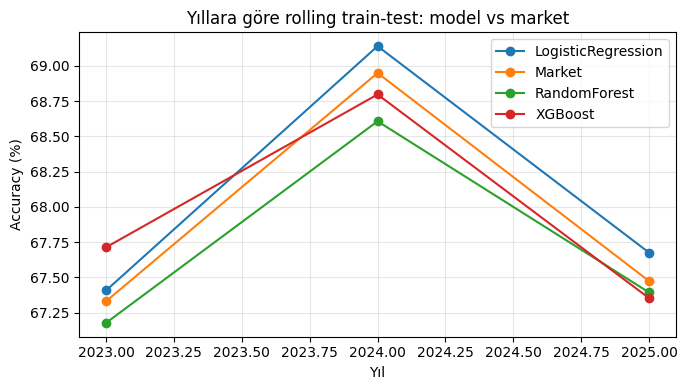

In [11]:
import matplotlib.pyplot as plt

if not results_long.empty:
    fig, ax = plt.subplots(figsize=(7, 4))

    for model_name in sorted(results_long["model"].unique()):
        sub = results_long[results_long["model"] == model_name]
        ax.plot(sub["year"], sub["accuracy"] * 100, marker="o", label=model_name)

    ax.set_xlabel("Yıl")
    ax.set_ylabel("Accuracy (%)")
    ax.set_title("Yıllara göre rolling train-test: model vs market")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Görselleştirecek sonuç yok.")